# Plotting exercice

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('data.csv')

In [85]:
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null object
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


## Data Preparation

In [87]:
# remove leap days
df = df[~((df['Date']=='2008-02-29')|(df['Date']=='2012-02-29'))]
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
# sort
df.sort_values(by='Date',inplace=True)
# convert from tenths of degrees to degrees
df['Data_Value'] = df['Data_Value']/10

## Part 1

In [88]:
# create sub-datasets
tmax = df[(df['Date']<'2015-01-01')&(df['Element']=='TMAX')][['Date','Data_Value']]
tmin = df[(df['Date']<'2015-01-01')&(df['Element']=='TMIN')][['Date','Data_Value']]

In [89]:
#groupby, creating series for axis
tmax = tmax.groupby('Date')['Data_Value'].max()
tmin = tmin.groupby('Date')['Data_Value'].min()

## Part 2

In [94]:
# Add month-day column
df['M-D'] = df['Date'].apply(lambda row: str(row.month) + '-' + str(row.day))
# divide dataset in two
df_14 = df[df['Date']<'2015-01-01']
df_15 = df[df['Date']>='2015-01-01']

In [95]:
# compute aggregation for each dataset
agg_14 = df_14.groupby(by='M-D')['Data_Value'].agg({'min','max'})
agg_15 = df_15.groupby(by='M-D')['Data_Value'].agg({'min','max'})
agg_14.columns = ['min_14','max_14']
agg_15.columns = ['min_15','max_15']
# concatenate aggregations
agg = pd.concat([agg_14,agg_15], axis=1)

In [97]:
# filter all time records from 2015
record_high = agg[(agg['max_15']>agg['max_14'])]
record_low = agg[(agg['min_15']<agg['min_14'])]

In [98]:
# reshape data_set
record_low = record_low[['min_14','min_15']]
record_low.reset_index(level=0,inplace=True)
print(record_low.shape)
record_high = record_high[['max_14','max_15']]
record_high.reset_index(level=0,inplace=True)
print(record_high.shape)

(32, 3)
(37, 3)


In [76]:
# Prepare min record till 2014
df_tmin = pd.DataFrame(tmin)
df_tmin.reset_index(inplace=True)
df_tmin['M-D'] = df_tmin['Date'].apply(lambda row: str(row.month) + '-' + str(row.day))

In [105]:
# Prepare max record till 2014
df_tmax = pd.DataFrame(tmax)
df_tmax.reset_index(inplace=True)
df_tmax['M-D'] = df_tmax['Date'].apply(lambda row: str(row.month) + '-' + str(row.day))

In [101]:
# Join min 2014 with min 2015
tmin_record = df_tmin.merge(record_low, how='inner', left_on=['Data_Value','M-D'], right_on=['min_14','M-D'])

In [106]:
# Join min 2014 with min 2015
tmax_record = df_tmax.merge(record_high, how='inner', left_on=['Data_Value','M-D'], right_on=['max_14','M-D'])

In [109]:
# Finalise all time low temperature data series
min_record_2015 = tmin_record[['Date','min_15']].set_index('Date')

In [110]:
# Finalise all time low temperature data series
max_record_2015 = tmax_record[['Date','max_15']].set_index('Date')

## Plotting

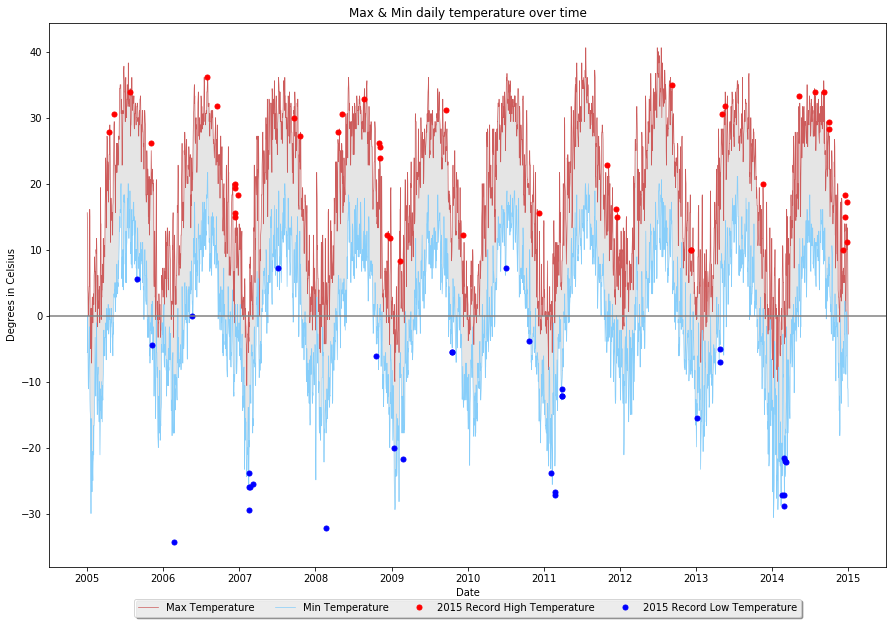

In [127]:
# initiate plot
plt.figure(figsize=(15,10))
plt.plot(tmax, '-', tmin, '-', max_record_2015, '.', min_record_2015, '.', ms=10)

# set ax object
ax = plt.gca()

# set line colors
# Color list: https://matplotlib.org/stable/gallery/color/named_colors.html
ax.get_lines()[0].set_color("indianred")
ax.get_lines()[1].set_color("lightskyblue")
ax.get_lines()[2].set_color("red")
ax.get_lines()[3].set_color("blue")

#set line thickness
plt.setp(ax.get_lines(), linewidth=0.7)

#set 0 line for y axis
plt.axhline(y=0, color='gray', linestyle='-')

# x axis series
x = ax.lines[0].get_xdata()
y1 = ax.lines[0].get_ydata()
y2 = ax.lines[1].get_ydata()
# shading area between lines
plt.gca().fill_between(x
                       ,y1
                       ,y2
                       ,facecolor='grey'
                       ,alpha=0.2
                        )

# set label 
ax.set_xlabel('Date')
ax.set_ylabel('Degrees in Celsius')
ax.set_title('Max & Min daily temperature over time')
# set legend
#L = plt.legend(loc='upper left')
L = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
L.texts[0].set_text('Max Temperature')
L.texts[1].set_text('Min Temperature')
L.texts[2].set_text('2015 Record High Temperature')
L.texts[3].set_text('2015 Record Low Temperature')